In [77]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import csv
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

# Hyperparameters and Constants

In [78]:
LOOK_BACK = 10
# Our input is composed of:
#  - LOOK_BACK values from trend,
#  - LOOK_BACK values from cycle, and
#  - 1 effect value.
HIDDEN_SIZE = 8
OUTPUT_FEATURES_NUM = 1
NUM_LAYERS = 1
max_epochs = 2000
LEARNING_RATE = 0.05
circle = 5  # how many cycles to repeat training for evaluation
WIN_SIZE  = 4            # window length inside the 10‑step segment
WIN_STEP  = 1            # 75 % overlap          
N_WINDOWS = (LOOK_BACK - WIN_SIZE) // WIN_STEP + 1  
INPUT_FEATURES_NUM = N_WINDOWS * 8 + 1   # 32 stats + 1 effect  

# 1. Data Import and Extraction Functions

In [79]:
def import_TSD_data(filename='dataset.csv'):
    """
    Loads data from CSV and extracts three 1D arrays:
      - trend: from 'rate'
      - cycle: from 'cycle'
      - effect: chosen as 'Precipitation'
    Returns these arrays along with the train/test split sizes.
    """
    dataset = pd.read_csv(filename)
    trend = dataset['rate'].values.astype('float32')
    cycle = dataset['cycle'].values.astype('float32')
    effect = dataset['indicator_norm'].values.astype('float32')
    train_size = int(0.6 * len(trend))
    test_size = len(trend) - train_size
    return trend, cycle, effect, train_size, test_size


def build_stats_features(trend, cycle, effect,
                         look_back=LOOK_BACK,
                         win_size=WIN_SIZE,
                         win_step=WIN_STEP,
                         target_offset=None):
    """
    Creates feature / target arrays.

    For every start index i:
      • take trend[i : i+look_back]  &  cycle[...]
      • carve into overlapping windows of length win_size, stride win_step
      • compute [min,max,mean,std] of rate & cycle  → 8 feats / window
      • flatten   (N_WINDOWS × 8)  and append effect[i + target_offset]
      • target is trend[i + target_offset]

    Returns
    -------
    X : (n_samples, N_WINDOWS*8 + 1)
    y : (n_samples,)
    """
    if target_offset is None:
        target_offset = 2 * look_back      

    n_samples = len(trend) - (look_back + target_offset)
    X, y = [], []
    for i in range(n_samples):
        r_seg = trend [i : i + look_back]
        c_seg = cycle [i : i + look_back]
        win_feats = []
        for w in range(0, look_back - win_size + 1, win_step):
            r_win = r_seg[w : w + win_size]
            c_win = c_seg[w : w + win_size]
            win_feats.extend([
                r_win.min(), r_win.max(), r_win.mean(), r_win.std(ddof=0),
                c_win.min(), c_win.max(), c_win.mean(), c_win.std(ddof=0)
            ])
        # append scalar effect of the *day you predict*
        eff_val = effect[i + target_offset]
        win_feats.append(eff_val)
        X.append(win_feats)
        y.append(trend[i + target_offset])

    return np.asarray(X, dtype='float32'), np.asarray(y, dtype='float32')

# 2. GRU Model Definition

In [80]:
class GRU_model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        """
        Model expects an input with:
         - first (input_size - 1) features: processed sequentially by GRU, and
         - the last feature: the effect value (used outside of GRU).
        """
        super(GRU_model, self).__init__()
        self.gru = nn.GRU((input_size - 1), hidden_size, num_layers)
        self.forwardProcessing = nn.Linear(hidden_size + 1, output_size)

    def forward(self, x_input):
        # x_input shape: (seq_length, batch, input_size)
        # The first (INPUT_FEATURES_NUM-1) columns are processed by GRU.
        x = x_input[:, :, 0:(INPUT_FEATURES_NUM - 1)]
        # The effect feature is the last column. Reshape to (1, batch, 1)
        e = x_input[:, :, (INPUT_FEATURES_NUM - 1)].reshape(1, x_input.shape[1], 1)
        x, _ = self.gru(x)  # x shape: (seq_length, batch, hidden_size)
        # Concatenate the GRU output with the effect feature.
        x = torch.cat([x, e], dim=2)
        s, b, h = x.shape
        x = x.view(s * b, h)
        x = self.forwardProcessing(x)
        x = x.view(s, b, -1)
        return x


# 3. Training and Evaluation Function

In [81]:
def TSD_GRU(gru_model, trend, cycle, effect, train_size, look_back):
    train_trend = trend[:train_size]
    test_trend  = trend[train_size:]
    train_cycle = cycle[:train_size]
    test_cycle  = cycle[train_size:]
    train_eff   = effect[:train_size]
    test_eff    = effect[train_size:]

    # ---------- build samples ------------------------------------------------
    train_x, train_y = build_stats_features(train_trend, train_cycle, train_eff,
                                            look_back=look_back)
    test_x,  test_y  = build_stats_features(test_trend,  test_cycle,  test_eff,
                                            look_back=look_back)

    # ---------- tensor shapes stay identical to your original code ----------
    bs_tr = train_x.shape[0]
    bs_te = test_x.shape[0]
    batch_size_train = train_x.shape[0]
    train_x_tensor = torch.tensor(train_x).reshape(1, bs_tr, INPUT_FEATURES_NUM)
    train_y_tensor = torch.tensor(train_y).reshape(1, bs_tr, OUTPUT_FEATURES_NUM)
    batch_size_test = test_x.shape[0]
    test_x_tensor  = torch.tensor(test_x ).reshape(1, bs_te, INPUT_FEATURES_NUM)
    test_y_tensor  = torch.tensor(test_y ).reshape(1, bs_te, OUTPUT_FEATURES_NUM)
    # Initialize arrays to store evaluation metrics across multiple training cycles.
    MSE_list = np.zeros([circle])
    RMSE_list = np.zeros([circle])
    RAE_list = np.zeros([circle])
    R2_list = np.zeros([circle])
    
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(gru_model.parameters(), lr=LEARNING_RATE)
    
    final_y_hat = None
    final_y_act = None
    for i in range(circle):
        print('Circle =', i)
        # Reinitialize model parameters (for independent training cycles)
        for name, parameter in gru_model.named_parameters():
            if parameter.requires_grad:
                parameter.data = torch.randn_like(parameter)
        
        # Training loop.
        for epoch in tqdm(range(max_epochs), desc="Training Progress"):
            optimizer.zero_grad()
            output = gru_model(train_x_tensor)
            loss = loss_function(output, train_y_tensor)
            loss.backward()
            optimizer.step()
            if (epoch + 1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{max_epochs}], Loss: {loss.item():.5f}")
                
        # --- Evaluation on Test Data ---
        with torch.no_grad():
            pre_y = gru_model(test_x_tensor)
        y_hat = pre_y.reshape(batch_size_test).detach().numpy()
        y_act = test_y_tensor.reshape(batch_size_test).detach().numpy()
        # Save the predictions from the final cycle.
        if i == circle - 1:
            final_y_hat = y_hat.copy()
            final_y_act = y_act.copy()
        # Compute error metrics.
        error = y_hat - y_act
        squared_error = np.multiply(error, error)
        
        MSE_list[i] = np.mean(squared_error)
        RMSE_list[i] = np.sqrt(MSE_list[i])
        RAE_list[i] = np.sum(np.abs(y_hat - y_act)) / np.sum(np.abs(np.mean(y_act) - y_act))
        RSS = np.sum(squared_error)
        TSS = np.sum(np.square(y_act - np.mean(y_act)))
        R2_list[i] = 1 - RSS / TSS
        
    avg_MSE = np.mean(MSE_list)
    avg_RMSE = np.mean(RMSE_list)
    avg_RAE = np.mean(RAE_list)
    avg_R2 = np.mean(R2_list)
    
    return avg_MSE, avg_RMSE, avg_RAE, avg_R2, final_y_act, final_y_hat

# 4. Main Routine

In [82]:
begin = time()
# Load the data from CSV.
trend, cycle, effect, train_size, test_size = import_TSD_data()
print("Data loaded. Train size:", train_size, "Test size:", test_size)

# Initialize the GRU model.
gru_model = GRU_model(input_size=INPUT_FEATURES_NUM, hidden_size=HIDDEN_SIZE, 
                        output_size=OUTPUT_FEATURES_NUM, num_layers=NUM_LAYERS)

# Train and evaluate the model using the TSD_GRU formulation.
avg_MSE, avg_RMSE, avg_RAE, avg_R2, final_y_act, final_y_hat = TSD_GRU(gru_model, trend, cycle, effect, train_size, LOOK_BACK)

print(f"\nFinal Evaluation Metrics:\nMSE: {avg_MSE:.5f}\nRMSE: {avg_RMSE:.5f}\nRAE: {avg_RAE:.5f}\nR2: {avg_R2:.5f}")

output_list = [avg_MSE, avg_RMSE, avg_RAE, avg_R2]
with open('output_metrics.csv', 'w', newline='') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerow(["MSE", "RMSE", "MAPE", "RAE", "R2"])
    csv_writer.writerow(output_list)
    
end = time()
print("Total run time: {:.2f} seconds".format(end - begin))


Data loaded. Train size: 9000 Test size: 6000
Circle = 0


Training Progress:   8%|▊         | 160/2000 [00:00<00:04, 386.13it/s]

Epoch [100/2000], Loss: 0.00525


Training Progress:  12%|█▏        | 240/2000 [00:00<00:04, 389.75it/s]

Epoch [200/2000], Loss: 0.00446


Training Progress:  18%|█▊        | 356/2000 [00:00<00:04, 348.91it/s]

Epoch [300/2000], Loss: 0.00412


Training Progress:  21%|██▏       | 428/2000 [00:01<00:04, 335.91it/s]

Epoch [400/2000], Loss: 0.00385


Training Progress:  25%|██▍       | 493/2000 [00:01<00:05, 292.10it/s]

Epoch [500/2000], Loss: 0.00365


Training Progress:  32%|███▏      | 633/2000 [00:02<00:05, 251.20it/s]

Epoch [600/2000], Loss: 0.00351


Training Progress:  38%|███▊      | 752/2000 [00:02<00:04, 272.40it/s]

Epoch [700/2000], Loss: 0.00339


Training Progress:  42%|████▏     | 842/2000 [00:02<00:03, 290.23it/s]

Epoch [800/2000], Loss: 0.00326


Training Progress:  47%|████▋     | 936/2000 [00:03<00:03, 274.58it/s]

Epoch [900/2000], Loss: 0.00314


Training Progress:  53%|█████▎    | 1052/2000 [00:03<00:03, 261.84it/s]

Epoch [1000/2000], Loss: 0.00304


Training Progress:  57%|█████▋    | 1132/2000 [00:03<00:03, 253.33it/s]

Epoch [1100/2000], Loss: 0.00294


Training Progress:  63%|██████▎   | 1261/2000 [00:04<00:02, 314.50it/s]

Epoch [1200/2000], Loss: 0.00284


Training Progress:  68%|██████▊   | 1352/2000 [00:04<00:02, 277.38it/s]

Epoch [1300/2000], Loss: 0.00275


Training Progress:  72%|███████▏  | 1435/2000 [00:05<00:02, 255.83it/s]

Epoch [1400/2000], Loss: 0.00266


Training Progress:  78%|███████▊  | 1558/2000 [00:05<00:01, 289.14it/s]

Epoch [1500/2000], Loss: 0.00263


Training Progress:  82%|████████▏ | 1645/2000 [00:05<00:01, 263.17it/s]

Epoch [1600/2000], Loss: 0.00254


Training Progress:  88%|████████▊ | 1754/2000 [00:06<00:00, 267.44it/s]

Epoch [1700/2000], Loss: 0.00246


Training Progress:  92%|█████████▏| 1847/2000 [00:06<00:00, 295.90it/s]

Epoch [1800/2000], Loss: 0.00241


Training Progress:  97%|█████████▋| 1935/2000 [00:06<00:00, 280.16it/s]

Epoch [1900/2000], Loss: 0.00235


Training Progress: 100%|██████████| 2000/2000 [00:07<00:00, 279.10it/s]


Epoch [2000/2000], Loss: 0.00233
Circle = 1


Training Progress:   7%|▋         | 135/2000 [00:00<00:07, 251.95it/s]

Epoch [100/2000], Loss: 0.01011


Training Progress:  13%|█▎        | 267/2000 [00:00<00:05, 321.49it/s]

Epoch [200/2000], Loss: 0.00485


Training Progress:  17%|█▋        | 343/2000 [00:01<00:04, 344.62it/s]

Epoch [300/2000], Loss: 0.00444


Training Progress:  22%|██▏       | 438/2000 [00:01<00:05, 263.24it/s]

Epoch [400/2000], Loss: 0.00416


Training Progress:  27%|██▋       | 548/2000 [00:01<00:05, 262.74it/s]

Epoch [500/2000], Loss: 0.00391


Training Progress:  32%|███▏      | 633/2000 [00:02<00:05, 268.72it/s]

Epoch [600/2000], Loss: 0.00370


Training Progress:  37%|███▋      | 742/2000 [00:02<00:04, 260.84it/s]

Epoch [700/2000], Loss: 0.00354


Training Progress:  42%|████▏     | 845/2000 [00:03<00:04, 238.92it/s]

Epoch [800/2000], Loss: 0.00342


Training Progress:  47%|████▋     | 942/2000 [00:03<00:04, 230.86it/s]

Epoch [900/2000], Loss: 0.00334


Training Progress:  52%|█████▏    | 1040/2000 [00:04<00:04, 233.43it/s]

Epoch [1000/2000], Loss: 0.00327


Training Progress:  57%|█████▋    | 1140/2000 [00:04<00:03, 237.03it/s]

Epoch [1100/2000], Loss: 0.00323


Training Progress:  63%|██████▎   | 1253/2000 [00:04<00:02, 266.56it/s]

Epoch [1200/2000], Loss: 0.00319


Training Progress:  69%|██████▊   | 1371/2000 [00:05<00:01, 347.76it/s]

Epoch [1300/2000], Loss: 0.00316


Training Progress:  72%|███████▏  | 1443/2000 [00:05<00:01, 319.50it/s]

Epoch [1400/2000], Loss: 0.00313


Training Progress:  77%|███████▋  | 1534/2000 [00:05<00:01, 265.31it/s]

Epoch [1500/2000], Loss: 0.00310


Training Progress:  81%|████████  | 1620/2000 [00:06<00:01, 268.15it/s]

Epoch [1600/2000], Loss: 0.00306


Training Progress:  87%|████████▋ | 1737/2000 [00:06<00:00, 268.50it/s]

Epoch [1700/2000], Loss: 0.00303


Training Progress:  92%|█████████▏| 1849/2000 [00:06<00:00, 331.87it/s]

Epoch [1800/2000], Loss: 0.00299


Training Progress:  98%|█████████▊| 1969/2000 [00:07<00:00, 373.21it/s]

Epoch [1900/2000], Loss: 0.00295


Training Progress: 100%|██████████| 2000/2000 [00:07<00:00, 271.85it/s]


Epoch [2000/2000], Loss: 0.00291
Circle = 2


Training Progress:   6%|▋         | 129/2000 [00:00<00:07, 239.27it/s]

Epoch [100/2000], Loss: 0.00629


Training Progress:  12%|█▏        | 246/2000 [00:00<00:06, 252.09it/s]

Epoch [200/2000], Loss: 0.00575


Training Progress:  18%|█▊        | 350/2000 [00:01<00:06, 247.51it/s]

Epoch [300/2000], Loss: 0.00370


Training Progress:  23%|██▎       | 451/2000 [00:01<00:05, 309.54it/s]

Epoch [400/2000], Loss: 0.00351


Training Progress:  28%|██▊       | 559/2000 [00:02<00:04, 337.50it/s]

Epoch [500/2000], Loss: 0.00332


Training Progress:  31%|███       | 624/2000 [00:02<00:04, 284.74it/s]

Epoch [600/2000], Loss: 0.00316


Training Progress:  37%|███▋      | 737/2000 [00:02<00:04, 256.87it/s]

Epoch [700/2000], Loss: 0.00278


Training Progress:  42%|████▏     | 840/2000 [00:03<00:04, 242.39it/s]

Epoch [800/2000], Loss: 0.00251


Training Progress:  47%|████▋     | 943/2000 [00:03<00:04, 249.56it/s]

Epoch [900/2000], Loss: 0.00234


Training Progress:  52%|█████▏    | 1045/2000 [00:04<00:03, 243.64it/s]

Epoch [1000/2000], Loss: 0.00241


Training Progress:  57%|█████▋    | 1131/2000 [00:04<00:03, 230.87it/s]

Epoch [1100/2000], Loss: 0.00220


Training Progress:  62%|██████▏   | 1243/2000 [00:04<00:03, 251.73it/s]

Epoch [1200/2000], Loss: 0.00216


Training Progress:  67%|██████▋   | 1348/2000 [00:05<00:02, 249.87it/s]

Epoch [1300/2000], Loss: 0.00214


Training Progress:  72%|███████▏  | 1439/2000 [00:05<00:02, 277.87it/s]

Epoch [1400/2000], Loss: 0.00211


Training Progress:  78%|███████▊  | 1555/2000 [00:05<00:01, 350.52it/s]

Epoch [1500/2000], Loss: 0.00209


Training Progress:  83%|████████▎ | 1668/2000 [00:06<00:00, 361.97it/s]

Epoch [1600/2000], Loss: 0.00208


Training Progress:  87%|████████▋ | 1748/2000 [00:06<00:00, 379.64it/s]

Epoch [1700/2000], Loss: 0.00206


Training Progress:  93%|█████████▎| 1868/2000 [00:06<00:00, 371.01it/s]

Epoch [1800/2000], Loss: 0.00205


Training Progress:  97%|█████████▋| 1947/2000 [00:06<00:00, 380.69it/s]

Epoch [1900/2000], Loss: 0.00203


Training Progress: 100%|██████████| 2000/2000 [00:07<00:00, 283.01it/s]


Epoch [2000/2000], Loss: 0.00203
Circle = 3


Training Progress:   8%|▊         | 150/2000 [00:00<00:05, 335.28it/s]

Epoch [100/2000], Loss: 0.00560


Training Progress:  13%|█▎        | 259/2000 [00:00<00:04, 354.47it/s]

Epoch [200/2000], Loss: 0.00437


Training Progress:  19%|█▊        | 373/2000 [00:01<00:04, 370.91it/s]

Epoch [300/2000], Loss: 0.00398


Training Progress:  21%|██        | 411/2000 [00:01<00:04, 326.48it/s]

Epoch [400/2000], Loss: 0.00380


Training Progress:  27%|██▋       | 547/2000 [00:01<00:05, 279.45it/s]

Epoch [500/2000], Loss: 0.00368


Training Progress:  32%|███▏      | 648/2000 [00:02<00:04, 309.64it/s]

Epoch [600/2000], Loss: 0.00358


Training Progress:  38%|███▊      | 752/2000 [00:02<00:03, 320.87it/s]

Epoch [700/2000], Loss: 0.00351


Training Progress:  43%|████▎     | 858/2000 [00:02<00:03, 343.04it/s]

Epoch [800/2000], Loss: 0.00345


Training Progress:  46%|████▋     | 927/2000 [00:02<00:03, 311.34it/s]

Epoch [900/2000], Loss: 0.00341


Training Progress:  53%|█████▎    | 1059/2000 [00:03<00:02, 317.69it/s]

Epoch [1000/2000], Loss: 0.00337


Training Progress:  58%|█████▊    | 1162/2000 [00:03<00:02, 305.31it/s]

Epoch [1100/2000], Loss: 0.00333


Training Progress:  63%|██████▎   | 1265/2000 [00:04<00:02, 325.81it/s]

Epoch [1200/2000], Loss: 0.00330


Training Progress:  66%|██████▋   | 1330/2000 [00:04<00:02, 279.83it/s]

Epoch [1300/2000], Loss: 0.00328


Training Progress:  72%|███████▏  | 1443/2000 [00:04<00:02, 273.41it/s]

Epoch [1400/2000], Loss: 0.00325


Training Progress:  77%|███████▋  | 1543/2000 [00:05<00:01, 296.72it/s]

Epoch [1500/2000], Loss: 0.00323


Training Progress:  82%|████████▏ | 1630/2000 [00:05<00:01, 257.63it/s]

Epoch [1600/2000], Loss: 0.00320


Training Progress:  88%|████████▊ | 1751/2000 [00:05<00:00, 276.19it/s]

Epoch [1700/2000], Loss: 0.00317


Training Progress:  92%|█████████▏| 1839/2000 [00:06<00:00, 267.05it/s]

Epoch [1800/2000], Loss: 0.00314


Training Progress:  97%|█████████▋| 1948/2000 [00:06<00:00, 245.86it/s]

Epoch [1900/2000], Loss: 0.00310


Training Progress: 100%|██████████| 2000/2000 [00:06<00:00, 287.48it/s]


Epoch [2000/2000], Loss: 0.00307
Circle = 4


Training Progress:   7%|▋         | 140/2000 [00:00<00:06, 306.00it/s]

Epoch [100/2000], Loss: 0.01947


Training Progress:  12%|█▎        | 250/2000 [00:00<00:05, 340.78it/s]

Epoch [200/2000], Loss: 0.01755


Training Progress:  18%|█▊        | 357/2000 [00:01<00:05, 326.66it/s]

Epoch [300/2000], Loss: 0.00590


Training Progress:  23%|██▎       | 460/2000 [00:01<00:04, 316.25it/s]

Epoch [400/2000], Loss: 0.00400


Training Progress:  28%|██▊       | 562/2000 [00:01<00:04, 313.84it/s]

Epoch [500/2000], Loss: 0.00362


Training Progress:  33%|███▎      | 666/2000 [00:02<00:04, 331.67it/s]

Epoch [600/2000], Loss: 0.00352


Training Progress:  37%|███▋      | 737/2000 [00:02<00:04, 306.74it/s]

Epoch [700/2000], Loss: 0.00347


Training Progress:  42%|████▏     | 831/2000 [00:02<00:03, 299.11it/s]

Epoch [800/2000], Loss: 0.00345


Training Progress:  46%|████▋     | 929/2000 [00:03<00:04, 262.95it/s]

Epoch [900/2000], Loss: 0.00342


Training Progress:  52%|█████▏    | 1039/2000 [00:03<00:03, 254.30it/s]

Epoch [1000/2000], Loss: 0.00340


Training Progress:  57%|█████▊    | 1150/2000 [00:03<00:03, 251.38it/s]

Epoch [1100/2000], Loss: 0.00339


Training Progress:  62%|██████▏   | 1244/2000 [00:04<00:02, 284.35it/s]

Epoch [1200/2000], Loss: 0.00337


Training Progress:  67%|██████▋   | 1342/2000 [00:04<00:02, 300.50it/s]

Epoch [1300/2000], Loss: 0.00336


Training Progress:  73%|███████▎  | 1451/2000 [00:04<00:01, 326.99it/s]

Epoch [1400/2000], Loss: 0.00334


Training Progress:  78%|███████▊  | 1558/2000 [00:05<00:01, 325.20it/s]

Epoch [1500/2000], Loss: 0.00333


Training Progress:  83%|████████▎ | 1653/2000 [00:05<00:01, 291.24it/s]

Epoch [1600/2000], Loss: 0.00332


Training Progress:  87%|████████▋ | 1744/2000 [00:05<00:00, 264.11it/s]

Epoch [1700/2000], Loss: 0.00330


Training Progress:  91%|█████████▏| 1828/2000 [00:06<00:00, 268.76it/s]

Epoch [1800/2000], Loss: 0.00329


Training Progress:  98%|█████████▊| 1969/2000 [00:06<00:00, 324.31it/s]

Epoch [1900/2000], Loss: 0.00328


Training Progress: 100%|██████████| 2000/2000 [00:06<00:00, 293.64it/s]

Epoch [2000/2000], Loss: 0.00327

Final Evaluation Metrics:
MSE: 0.00502
RMSE: 0.07080
RAE: 0.20867
R2: 0.94028
Total run time: 38.55 seconds


# 5. Plot Actual vs. Predicted Values

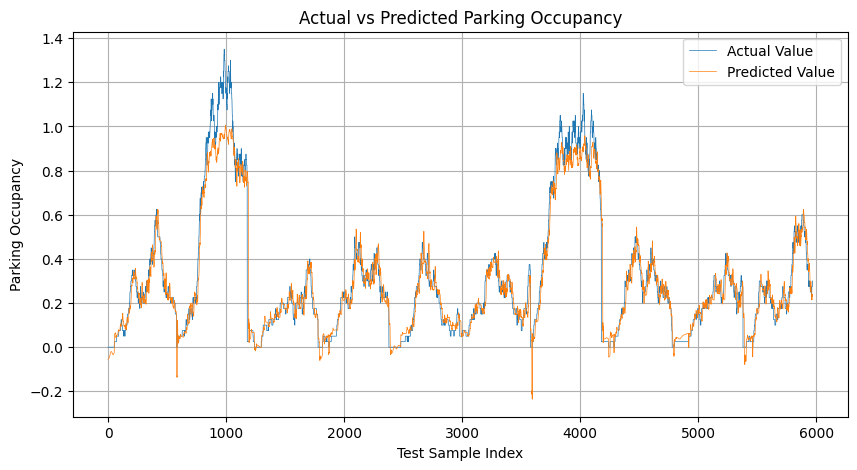

In [83]:
plt.figure(figsize=(10,5))
plt.plot(final_y_act, label="Actual Value", linewidth=0.5)
plt.plot(final_y_hat, label="Predicted Value", linewidth=0.5)
plt.xlabel("Test Sample Index")
plt.ylabel("Parking Occupancy")
plt.title("Actual vs Predicted Parking Occupancy")
plt.legend()
plt.grid(True)
# plt.show()
plt.savefig("actual_vs_predicted.png", dpi=300, bbox_inches='tight')